In [1]:
import numpy
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import np_utils
import os
from datetime import datetime
import matplotlib.pyplot as plt
import sys
import math        #import needed modules
import pyaudio     #sudo apt-get install python-pyaudio
import pandas as pd
from sklearn.model_selection import train_test_split
import random

Using TensorFlow backend.


In [2]:
epochs = 60
stepsPerEpochs= 20
VALIDATION_SIZE = 1
BATCH_SIZE = 128
checkpoint ="weights-improvement-{epoch:02d}-{loss:.4f}-bigger.hdf5"
seq_length = 200


# load ascii text and covert to lowercase
filename = "wonderlandFull.txt"
filenameTest = "wonderlandTest.txt"

In [3]:

raw_text = open(filename, 'r', encoding='utf-8').read()
raw_text = raw_text.lower()

# create mapping of unique chars to integers
chars = sorted(list(set(raw_text)))
char_to_int = dict((c, i) for i, c in enumerate(chars))
int_to_char = dict((i, c) for i, c in enumerate(chars))
# summarize the loaded data
n_chars = len(raw_text)
n_vocab = len(chars)
print("Total Characters: ", n_chars)
print("Total Vocab: ", n_vocab)

Total Characters:  164200
Total Vocab:  64


In [4]:
# define the LSTM model
model = Sequential()
model.add(LSTM(256, input_shape=(seq_length, 1), return_sequences=True))

model.add(Dropout(0.2))
#model.add(LSTM(256, return_sequences=True))
#model.add(Dropout(0.2))
model.add(LSTM(256))
model.add(Dropout(0.2))
model.add(Dense(len(char_to_int), activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])


W0929 15:32:09.782353 15176 deprecation_wrapper.py:119] From c:\users\t-gamer\documents\git\projetointeligenciaartificialsistemasugestao\gpuvenv\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0929 15:32:09.797353 15176 deprecation_wrapper.py:119] From c:\users\t-gamer\documents\git\projetointeligenciaartificialsistemasugestao\gpuvenv\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0929 15:32:09.799354 15176 deprecation_wrapper.py:119] From c:\users\t-gamer\documents\git\projetointeligenciaartificialsistemasugestao\gpuvenv\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0929 15:32:10.119058 15176 deprecation_wrapper.py:119] From c:\users\t-gamer\documents\git\projetointeligenciaartificialsist

In [5]:

if os.path.isfile(checkpoint):
    model.load_weights(checkpoint)

mc = ModelCheckpoint(checkpoint, monitor='loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100, min_delta=0.000001)
callbacks=[es, mc]

In [6]:

# Load data
def generate_arrays_from_file(path, batchsize):
    dataX = []
    dataY = []
    batchcount = 0
    while True:
        with open(path) as f:

            for i in range(0, n_chars - seq_length, 1):
                seq_in = raw_text[i:i + seq_length]
                seq_out = raw_text[i + seq_length]
                dataX.append([char_to_int[char] for char in seq_in])
                dataY.append(char_to_int[seq_out])

                batchcount += 1

                if batchcount > batchsize:
                    X = numpy.reshape(dataX, (batchsize+1, seq_length, 1))
                    
                    onehot_encoded = list()

                    for data in dataY:
                        letter = [0 for _ in range(n_vocab)]
                        letter[data] = 1

                        onehot_encoded.append(letter)
                        
                    y = numpy.array(onehot_encoded)
                        
                    #print(len(y[0]),y[0])
                    yield (X, y)                    
                    dataX = []
                    dataY = []
                    batchcount = 0
             

In [7]:
history = model.fit_generator( generate_arrays_from_file(filename,BATCH_SIZE), epochs=epochs, steps_per_epoch=stepsPerEpochs, verbose=1, validation_data=generate_arrays_from_file(filenameTest,BATCH_SIZE),callbacks = callbacks, validation_steps=10)

W0929 15:32:13.926696 15176 deprecation.py:323] From c:\users\t-gamer\documents\git\projetointeligenciaartificialsistemasugestao\gpuvenv\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/60
20/20 [==============================] - 16s 814ms/step - loss: 3.3084 - acc: 0.1488 - val_loss: 3.1782 - val_acc: 0.1651

Epoch 00001: loss improved from inf to 3.30842, saving model to weights-improvement-01-3.3084-bigger.hdf5
Epoch 2/60
20/20 [==============================] - 14s 685ms/step - loss: 3.0690 - acc: 0.1756 - val_loss: 2.9263 - val_acc: 0.1915

Epoch 00002: loss improved from 3.30842 to 3.06896, saving model to weights-improvement-02-3.0690-bigger.hdf5
Epoch 3/60
20/20 [==============================] - 14s 685ms/step - loss: 2.9344 - acc: 0.2050 - val_loss: 2.8745 - val_acc: 0.2271

Epoch 00003: loss improved from 3.06896 to 2.93437, saving model to weights-improvement-03-2.9344-bigger.hdf5
Epoch 4/60
20/20 [==============================] - 14s 683ms/step - loss: 3.0504 - acc: 0.1895 - val_loss: 2.9570 - val_acc: 0.1736

Epoch 00004: loss did not improve from 2.93437
Epoch 5/60
20/20 [==============================] - 14s 683ms/step - loss: 2.8663 - acc: 0.

20/20 [==============================] - 13s 675ms/step - loss: 2.5493 - acc: 0.2822 - val_loss: 2.5803 - val_acc: 0.2744

Epoch 00041: loss improved from 2.57559 to 2.54929, saving model to weights-improvement-41-2.5493-bigger.hdf5
Epoch 42/60
20/20 [==============================] - 14s 675ms/step - loss: 2.5898 - acc: 0.2705 - val_loss: 2.4099 - val_acc: 0.3442

Epoch 00042: loss did not improve from 2.54929
Epoch 43/60
20/20 [==============================] - 13s 675ms/step - loss: 2.6705 - acc: 0.2457 - val_loss: 2.6076 - val_acc: 0.2752

Epoch 00043: loss did not improve from 2.54929
Epoch 44/60
20/20 [==============================] - 13s 674ms/step - loss: 2.6266 - acc: 0.2674 - val_loss: 2.6328 - val_acc: 0.2744

Epoch 00044: loss did not improve from 2.54929
Epoch 45/60
20/20 [==============================] - 14s 678ms/step - loss: 2.5324 - acc: 0.2953 - val_loss: 2.5945 - val_acc: 0.2457

Epoch 00045: loss improved from 2.54929 to 2.53237, saving model to weights-improvemen

<module 'matplotlib.pyplot' from 'c:\\users\\t-gamer\\documents\\git\\projetointeligenciaartificialsistemasugestao\\gpuvenv\\lib\\site-packages\\matplotlib\\pyplot.py'>

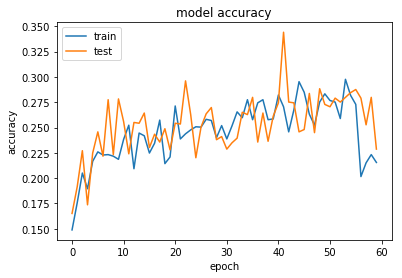

In [8]:
time = datetime.now()
timestampStr = time.strftime("%d %b %Y %H %M %S %f)")
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt

<module 'matplotlib.pyplot' from 'c:\\users\\t-gamer\\documents\\git\\projetointeligenciaartificialsistemasugestao\\gpuvenv\\lib\\site-packages\\matplotlib\\pyplot.py'>

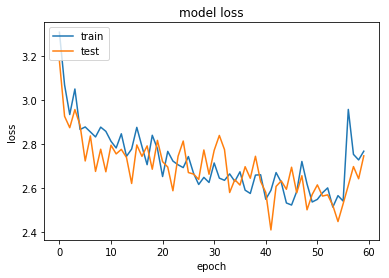

In [9]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig("loss"+timestampStr+".png")
plt

- Teste

In [22]:
testText = '''
The president’s tax returns reveal another grand twist that has never been truly told — how the popularity of that fictional alter ego rescued him, providing a financial lifeline to reinvent himself yet again. And then how, in an echo of the boom-and-bust cycle that has defined his business career, he led himself toward the financial shoals he must navigate today.
Mr. Trump’s genius, it turned out, wasn’t running a company. It was making himself famous — Trump-scale famous — and monetizing that fame.
By analyzing the tax records, The New York Times was able to place a value on Mr. Trump’s celebrity. While the returns show that he earned some $197 million directly from “The Apprentice” over 16 years — roughly in line with what he has claimed — they also reveal that an additional $230 million flowed from the fame associated with it."
'''
dataTestX = []
seq_in = testText[0: seq_length].lower()

dataTestX.append([char_to_int[char] for char in seq_in])

In [23]:
print(seq_in)


the president’s tax returns reveal another grand twist that has never been truly told — how the popularity of that fictional alter ego rescued him, providing a financial lifeline to reinvent himself 


In [24]:
testX = numpy.reshape(dataTestX, (1, seq_length, 1))

prediction = model.predict(testX, verbose=0)
index = numpy.argmax(prediction)
print(int_to_char[index])

a


In [25]:
resultado = ""
for i in range(100):
    testX = numpy.reshape(dataTestX, (1, seq_length, 1))

    prediction = model.predict(testX, verbose=0)
    index = numpy.argmax(prediction)
    
    resultado += int_to_char[index]
    
    dataTestX[0].pop(0) 
    dataTestX[0].append(index)



In [26]:
resultado
                        

'a po the pr the pr the pr the pr the pr the pr the pr the pr the pr the pr the pr the pr the pr the '

In [27]:
print(seq_in + resultado)


the president’s tax returns reveal another grand twist that has never been truly told — how the popularity of that fictional alter ego rescued him, providing a financial lifeline to reinvent himself a po the pr the pr the pr the pr the pr the pr the pr the pr the pr the pr the pr the pr the pr the 
